In [2]:
# Imports

import pandas as pd
from edbo.utils import Data
import numpy as np
from edbo.bro import BO_express
from gpytorch.priors import GammaPrior
import matplotlib.pyplot as plt


In [3]:
temperature_array = np.linspace(30,140,110,dtype=int)
time_array = np.linspace(10,45,35,dtype=int)
stoichiometry_array = np.linspace(33,66,33, dtype=int)

temperature_list = temperature_array.tolist()
time_list = time_array.tolist()
stoichiometry_list = stoichiometry_array.tolist()

In [4]:
#parameters in reaction space

components = { 'temperature': temperature_list,        # discrete grid of temperatures
                'time': time_list,              # discrete grid of time
                'stoichiometry': stoichiometry_list          # discrete grid of stoichiometry
                }

encoding = {'temperature':'numeric',                    #numerical encoding
            'time':'numeric',                           #numerical encoding
            'stoichiometry':'numeric'}                  #numerical encoding

In [5]:
from edbo.bro import BO_express

# BO object

bo = BO_express(components,                                 # Reaction parameters
                encoding=encoding,                          # Encoding specification
                acquisition_function='EI',                  # Use expectation value of improvement
                init_method='rand',                         # Use random initialization
                batch_size=3,                               # 3 experiments per round
                target='response')                          # Optimize response

# BO_express actually automatically chooses priors
# We can reset them manually to make sure they match the ones from our paper

from gpytorch.priors import GammaPrior

bo.lengthscale_prior = [GammaPrior(2.0, 0.2), 3.0]
bo.outputscale_prior = [GammaPrior(5.0, 0.5), 4.0]
bo.noise_prior = [GammaPrior(1.5, 0.5), 0.5]

In [6]:
def plot_kb_projections(n=2):
    """
    Plot 1D projection of Kriging believer parallel batch selection algorithm.
    """

    fig, ax = plt.subplots(len(bo.acq.function.projections[:n]),1, figsize=(12, n * 12 / 5))
    for i, p in enumerate(bo.acq.function.projections[:n]):
        ax[i].plot(range(len(p)), p, color='C' + str(i))
        ax[i].plot([np.argmax(p)], p[np.argmax(p)], 'X', markersize=10, color='black')
        ax[i].set_xlabel('X')
        ax[i].set_ylabel('EI')
        ax[i].set_title('Kriging Believer Projection:' + str(i))
    
    plt.tight_layout()
    plt.show()

In [7]:
def workflow(export_path):
    """
    Function for our BO pipeline.
    """
    
    bo.run()
    bo.plot_convergence()
    bo.model.regression()
    plot_kb_projections()
    bo.export_proposed(export_path)

In [8]:
bo.init_sample(seed=1)                 # Initialize
bo.export_proposed('round0.csv')     # Export design to a CSV file
bo.get_experiments()                   # Print selected experiments

,temperature_index,time_index,stoichiometry_index
58945,81,11,40
63703,85,15,46
61230,83,10,48


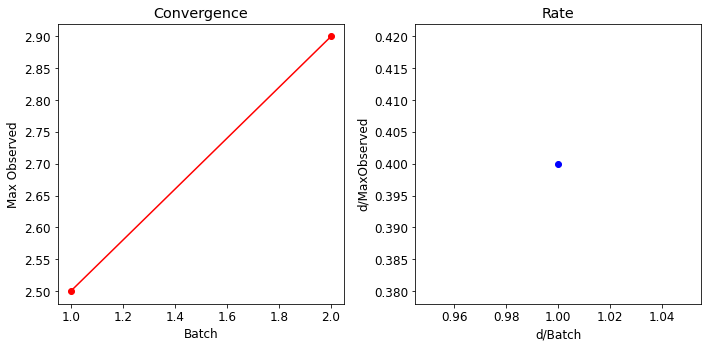

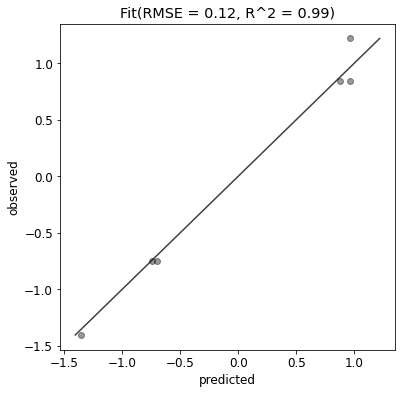

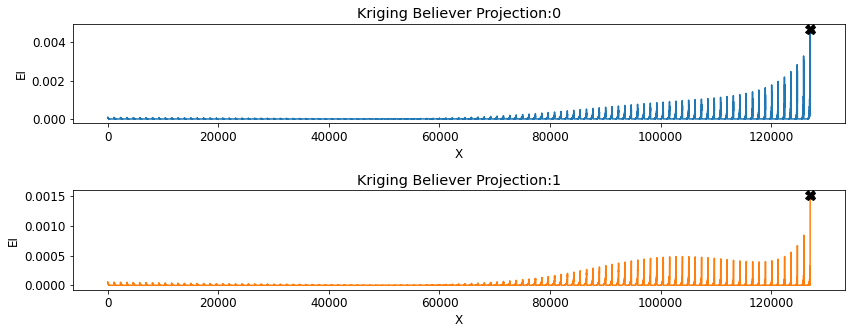

In [10]:
bo.add_results('results/round2.csv')       # Load real results from our experiments
workflow('round3.csv')                     # Run the workflow and export the next experiments to 'round1.csv'